In [1]:
import SGy139
import numpy as np
import matplotlib.pyplot as plt

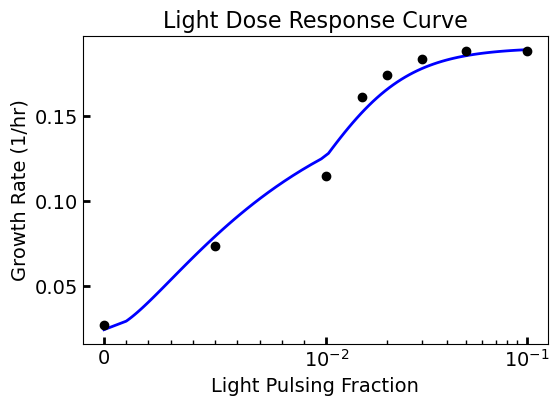

In [2]:
pulse_arr, mu_arr = SGy139.makeLightDoseResponseCurve(parameters=SGy139.get_pars(nE=2))


In [3]:
len(pulse_arr)

101

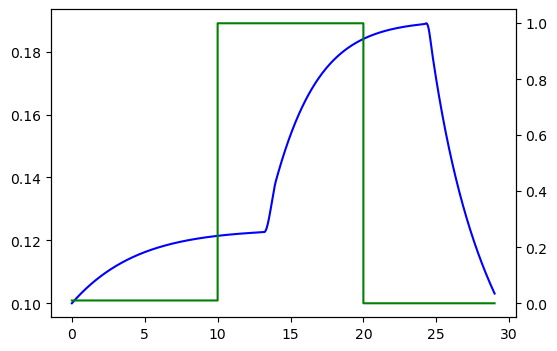

In [4]:
from numpy import interp

pulse_arr = np.array([0.01] * 10 + [1] * 10 + [0] * 10)
time_arr = np.linspace(0, 29, 30)

pulse_fun = lambda t: interp(t, time_arr, pulse_arr)

x0 = [0.1]

time_out, pulse_out, mu_out = SGy139.integrate(x0, time_arr, pulse_fun)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(time_out, mu_out, 'b', label='mu')
ax2 = ax.twinx()
ax2.plot(time_out, pulse_out, 'g', label='pulse')

In [9]:
x0 = [0.1]

t_history = np.array([0, 1, 2])
L_history = np.array([0.01, 0.01, 0.01])
mu_history = np.array([np.nan, np.nan, x0[0]])

guess = None

setpoint = 0.06

def setpoint_fun(t):
    out = np.zeros_like(t)
    out[t < 25] = 0.06
    out[t >= 25] = 0.1

    return out

# def setpoint_fun(t):
#     return np.sin(t/10) * 0.04 + 0.1

time_horizon = 10
sampling_rate = 0.5

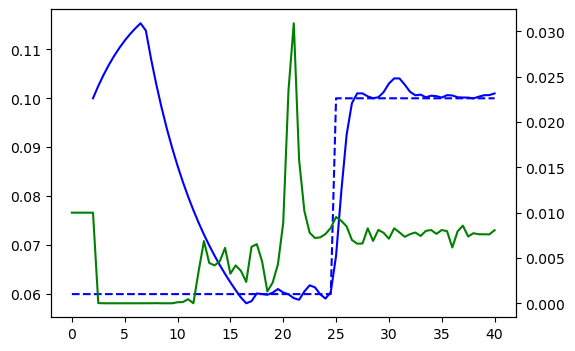

In [12]:
t_end = 40
t_current = t_history[-1]

while t_current < t_end:
    setpoint = setpoint_fun(t_current)

    out = SGy139.optimizeLight(x0, L_history[-1], t_history, L_history, setpoint_fun, time_horizon, sampling_rate, guess)#, parameters=SGy139.get_pars(nE=2))
    time_out, pulse_out, mu_out = SGy139.integrate(x0, np.arange(0, time_horizon, sampling_rate), pulse_fun)

    time_array = np.arange(sampling_rate, time_horizon, sampling_rate) + t_current

    full_time_array = np.concatenate((t_history, time_array))
    full_light_array = np.concatenate((L_history, out))

    # def pulse_fun(t):
    #     if t < full_time_array[0]:
    #         return full_light_array[0]
    #     elif t > full_time_array[-1]:
    #         return full_light_array[-1]
    #     else:
    #         return full_light_array[full_time_array <= t][-1] 
        
    def pulse_fun(t):
        t = np.array(t)
        if t.size == 1:
            if t < full_time_array[0]:
                return full_light_array[0]
            elif t > full_time_array[-1]:
                return full_light_array[-1]
            else:
                return full_light_array[t >= full_time_array][-1]
        output = np.zeros_like(t)
        for i in range(t.size):
            if t[i] < full_time_array[0]:
                output[i] = full_light_array[0]
            elif t[i] > full_time_array[-1]:
                output[i] = full_light_array[-1]
            else:
                output[i] = full_light_array[t[i] >= full_time_array][-1]

        return output
        
    time_out, pulse_out, mu_out = SGy139.integrate(x0, np.array([t_current, t_current+sampling_rate]), pulse_fun)

    t_current += sampling_rate
    t_history = np.append(t_history, t_current)
    L_history = np.append(L_history, out[0])
    mu_history = np.append(mu_history, mu_out[-1])
    x0 = [mu_out[-1]]

    guess = np.concatenate((out[1:], out[[-1]]))

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(t_history, mu_history, 'b', label='mu')
ax.plot(t_history, setpoint_fun(t_history), 'b--', label='setpoint')
ax2 = ax.twinx()
ax2.plot(t_history, L_history, 'g', label='pulse')

IndexError: index -1 is out of bounds for axis 0 with size 0

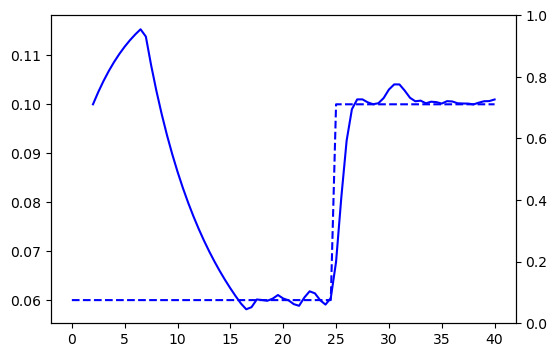

In [13]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(t_history, mu_history, 'b', label='mu')
ax.plot(t_history, setpoint_fun(t_history), 'b--', label='setpoint')
ax2 = ax.twinx()
t_interpolate = np.linspace(t_history[0], t_history[-1], 1000)
ax2.plot(t_interpolate, pulse_fun(t_interpolate), 'g', label='pulse')